<img src="https://www.gov.br/cbpf/pt-br/assuntos/noticias/titular-tem-artigo-em-periodico-de-prestigio/cbpf.png"  width="500" />

# Simulation-Based Inference: <font color="#FF7F50">Neural Posterior Estimation (NPE)</font> Tutorial
This repository contains a tutorial notebook demonstrating the implementation of Neural Posterior Estimation (NPE), a powerful method in simulation-based inference. 


NPE can be employed in two primary configurations:

- Sequential Neural Posterior Estimation (SNPE)

- Amortized Neural Posterior Estimation (ANPE)

## Usage:

Explore the world of simulation-based inference, also known as likelihood-free inference (LFI) or SBI, through this Jupyter notebook. Gain insights into the Neural Posterior Estimation method and its applications.

### Installation
To use this notebook, please ensure that you have the following libraries installed:
- PyTorch
- NumPy
- SBI
- kilonovanet [Simulator]

To install the SBI package, visit https://www.mackelab.org/sbi/

Refer to the last cell of the notebook for essential functions and libraries.


### Credits
This project was developed by Phelipe Darc  and contributors from CBPF (2024).


- E-mail: phelipedarc@gmail.com



### Extra Reading:

- Article: [Simulation Based Inference of BNS Kilonova Properties: A Case Study with AT2017gfo](https://arxiv.org/abs/2311.09471)

- Webpage: [SBI tutorial by Cranmer](https://astroautomata.com/blog/simulation-based-inference/)

- Article: [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429)

Feel free to explore and contribute to advance simulation-based inference methods! 🚀

---

# <font color="#191970">Simulation-Based Inference <font>Setup

In order to use simulation-based inferece its necessary two things:

1) A *Simulator* that takes a set of parameters and produce an observable (In this tutorial we are going to use Kilonovanet)

2) A *Prior* distribution for each parameters that the Simulator uses as input.

<font color="#191970"> In this tutorial we are going to use *Kilonovanet* (Simulator) which takes a set of parameters **[Mej,dyn, Mej,pm, ϕ, cos(θobs)]** and a list of days after the merger to produce a kilonova **spectra** (or Light Curve).<font>

In [ ]:
%pip install sbi==0.22
%pip install kilonovanet

In [5]:
# Simulator:
metadata = 'metadata_bulla_bns.json'
model_file = 'bulla-bns-latent-20-hidden-1000-CV-4-2021-04-21-epoch-200.pt'
model = kilonovanet.Model(metadata, model_file)

FileNotFoundError: [Errno 2] No such file or directory: 'metadata_bulla_bns.json'

In [9]:
# set prior distribution for the parameters
prior = utils.BoxUniform(low = torch.tensor([1e-3, 1e-2, 0.0, 0.0]), 
                         high = torch.tensor([2e-2, 0.13, 90, 1.0]))
#prior that wil be used in training the NPE model on GPUs
prior_cuda = utils.BoxUniform(low = torch.tensor([1e-3, 1e-2, 0.0, 0.0]), 
                         high = torch.tensor([2e-2, 0.13, 90, 1.0]), device='cuda')
#Range of our input spectral data
wl_sim = np.linspace(5000.0, 8000.0, 550)
print('Range of the Spectra: 5000 - 8000')

Range of the Spectra: 5000 - 8000


In [28]:
#SBI function that samples the uniform prior and generates spectra using the function <simulate_spec>
#Number of simulations
NUM_SIM = 10000

# make a SBI-wrapper on the simulator object for compatibility
simulator, prior = prepare_for_sbi(simulate_spec, prior)

#simulated data points
theta_j, X_j = simulate_for_sbi(simulator, proposal=prior, num_simulations=NUM_SIM)

#Tensor to Numpy array [optional]
X_j = np.array(X_j).astype(float)
theta_j = np.array(theta_j).astype(float)
#Changing the shape from (N,values,channels) to (N,channels,values)
X_j = np.swapaxes(X_j[:,:,:],1,2)
#[optional] You can split this Dataset into Validation, Train and Test or You can also generate more spectra using the simulate_for_sbi function

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

## Amortized Neural Posterior Estimation <font color="#FF7F50">(ANPE)<font>

The basic idea behind an Amortized Neural posterior estimation is to first train a model (training
phase) – specifically, a density estimator – that is not focused on any particular observation. Instead,
it learns to be a versatile estimator that attempts to approximate all posteriors supported by the prior.
Once trained, the density estimator can, in the second phase (inference), quickly and continually
infer parameters of BNS kilonovae from their spectra. To train the Network, we can simulate using
prior-draw parameters to build a dataset, of kilonova parameters (**θj**) and their respective spectra (**Xj**),
and minimize the Loss function over the weights. Once the density estimator has been trained on
simulated data x, it can then be applied to empirical data **X0** to compute the posterior.

### Embedding Nets

SBI provides a feature to understand summary statistics from simulation results using a neural network called embedding_net. When you specify an embedding_net, the simulation results go through it, and its outputs are used by the neural density estimator. The embedding_net's parameters are learned along with the neural density estimator's parameters. SBI includes preset embedding networks like MLP, CNN, and permutation-invariant networks, or you can use your own custom-written embedding networks.

Obs: only SNPE and SNRE methods can use an embedding_net to learn summary statistics from simulation outputs. SNLE does not offer this functionality since the simulation outputs x are the outputs of the neural density estimator.


In [29]:
#Example of a Custom Embedding Net 
class Embedding_net_Darc(nn.Module):
    def __init__(self,filters1,filters2,filters3,ks1,ks2,ks3,lstm1,lstm2,outfeat):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=filters1, kernel_size=2,padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=ks1, stride=ks1)
        self.conv2 = nn.Conv1d(in_channels=filters1, out_channels=filters2, kernel_size=2,padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=ks2, stride=ks2)
        self.conv3 = nn.Conv1d(in_channels=filters2, out_channels=filters3, kernel_size=2,padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=ks3, stride=ks3)
        self.lstm = nn.LSTM(input_size=filters3, hidden_size=lstm1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm1*2, hidden_size=lstm2, bidirectional=True, batch_first=True)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int((lstm2*2)*(int((550)/(ks1*ks2*ks3)))), out_features=outfeat)
        self.act4 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = torch.permute(x, (0,2,1)) 
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        return x

#---------Embedding_net_Darc HYPERPARAMETERS--------------------------------------
testefilters1=128
testefilters2=128
testefilters3=64
testeks1= 2
testeks2= 2
testeks3= 3
testelstm1= 300
testelstm2= 300
testeoutfeat = 100
#-------------------------------------------------------------------------
embed_net = Embedding_net_Darc(testefilters1,testefilters2,testefilters3,testeks1,testeks2,testeks3,testelstm1,testelstm2,testeoutfeat)

### Density estimators available:

- **MDN**: Mixture Density Network
- **MAF**: Masked Autoregressive Flow (Normalizing Flows)
- **NSF**: Neural Spline Flow (Normalizing Flows)
- **MADE**: Masked autoencoder for distribution estimation


### Inference procedure

In [30]:
#------------------TRAINING PARAMETERS--------------------------------------------------------
batch_size=512
stop_epoch=40
max_epochs=230
combined_loss=False
retrain_from_scratch1=True
#--------------------DENSITY ESTIMATOR PARAMETERS----------------------------------------------
MODEL = 'mdn'
num_bins=50 
num_transforms=4
hidden_features=10
#-----------------------------------------------------------------------------------------------
density_estimator_build_fn = posterior_nn(model=MODEL,embedding_net=embed_net,
                                          num_bins=num_bins,num_transforms =num_transforms,
                                          hidden_features=hidden_features)
#-----------------------------------------------------------------------------------------------
anpe =SNPE(prior=prior_cuda, density_estimator=density_estimator_build_fn,device='cpu')
#-----------------------------------------------------------------------------------------------
anpe.append_simulations(
    torch.as_tensor(theta_j.astype(np.float32)).to('cpu'),
    torch.as_tensor(X_j.astype(np.float32)).to('cpu'))
#-----------------------------------------------------------------------------------------------
p_x_y_estimator = anpe.train(training_batch_size=batch_size,stop_after_epochs=stop_epoch,
                             max_num_epochs=max_epochs,use_combined_loss=False,
                             show_train_summary=True,retrain_from_scratch=retrain_from_scratch1)

 Training neural network. Epochs trained: 231
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 231
        Best validation performance: 8.0188
        -------------------------
        


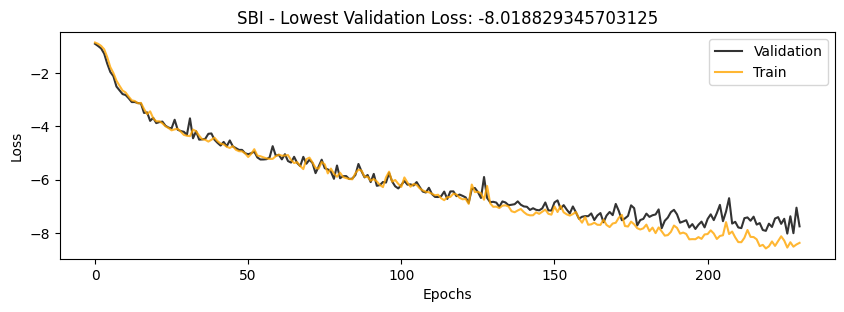

In [32]:
plt.figure(dpi=100,figsize=(10,3))
plt.plot(np.array(anpe._summary['validation_log_probs'])*-1, label='Validation', color='black',alpha=0.8)
plt.plot(np.array(anpe._summary['training_log_probs'])*-1, label='Train', color='orange',alpha=0.8)
plt.title(f'SBI - Lowest Validation Loss: { -1*anpe._summary["best_validation_log_prob"][0] }')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#After the Training phase is over we are able to use the NPE method to make bayesian inference in any data supported by our prior
#-----------------------------------------------------------------------------------------------
#we can use this density estimator to build the posterior:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)
#-----------------------------------------------------------------------------------------------
#Save the Trained Density estimator:
# model_filename = "Model.pkl"
#     with open(model_filename, "wb") as handle:
#         pickle.dump(hatp_x_y, handle)

Now, this hatp_x_y is ready to be used to produce posterior distributions in mere seconds for any spectral data that meets the requirements of our input data.
The evaluation of the model and diagnostic tools will be explored in another notebook, which is also available in this GitHub repository.

## Sequential Neural Posterior Estimation <font color="#FF7F50">(SNPE)<font>
In the previous tutorials, we have inferred the posterior using Amortized Inference in a single round of training. In single-round inference, we draw parameters from the prior, simulate the corresponding data, and then train a neural network to obtain the posterior. However, if one is interested in only one particular observation **x_o** sampling from the prior can be inefficient in the number of simulations because one is effectively learning a posterior estimate for all observations in the prior space. In this tutorial, we show how one can alleviate this issue by performing multi-round inference with sbi.

<font color="#FF7F50"> Sequential Neural Posterior Estimation: <font> 
    
It also starts by drawing parameters from the prior, simulating them, and training a neural network to estimate the posterior distribution. Afterwards, however, it continues inference in multiple rounds, focusing on a particular observation x_o. In each new round of inference, it draws samples from the obtained posterior distribution conditioned (the proposal posterior) at x_o (instead of from the prior), simulates these, and trains the network again. This process can be repeated arbitrarily often to get increasingly good approximations to the true posterior distribution at x_o. 

However minimizling the Loss function using the the proposal posterior as prior no longer yels the true posterior and it requires corrections:
SBI methods employing neural conditional density estimators differ primarily in how they deal with this problem,with three main approaches developed so far:

### SNPE-A
**Fast ε-free Inference of Simulation Models with Bayesian Conditional Density Estimation**<br> by Papamakarios & Murray (NeurIPS 2016) <br>[[PDF]](https://papers.nips.cc/paper/6084-fast-free-inference-of-simulation-models-with-bayesian-conditional-density-estimation.pdf) [[BibTeX]](https://papers.nips.cc/paper/6084-fast-free-inference-of-simulation-models-with-bayesian-conditional-density-estimation/bibtex)


In [ ]:
Inference = SNPE_A(prior)
proposal = prior
for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

### SNPE-C
**Automatic posterior transformation for likelihood-free inference**<br>by Greenberg, Nonnenmacher & Macke (ICML 2019) <br>[[PDF]](http://proceedings.mlr.press/v97/greenberg19a/greenberg19a.pdf)

In [ ]:
from sbi.inference import SNPE
inference = SNPE(prior)
proposal = prior
for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

### TSNPE
**Truncated proposals for scalable and hassle-free simulation-based inference** <br> by Deistler, Goncalves & Macke (NeurIPS 2022) <br>[[Paper]](https://arxiv.org/abs/2210.04815)

In [ ]:
from sbi.inference import SNPE
from sbi.utils import get_density_thresholder, RestrictedPrior

inference = SNPE(prior)
proposal = prior
for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(x_o)

    accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
    proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection")

# Functions 

In [3]:
import os, sys
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from torch import nn
import scipy
import kilonovanet
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from scipy import stats as st
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNLE, ratio_estimator_based_potential, SNRE_A,SNRE,SNPE
from sbi.inference import likelihood_estimator_based_potential, ImportanceSamplingPosterior, MCMCPosterior
import torch
from sbi.utils.get_nn_models import posterior_nn
import pickle
import math
# Function to apply smoothing to the input array using a Gaussian filter
def flux_smoothed(arr, sigma):
    # Conversion factor from parsecs to centimeters
    pc_to_cm = 3.086e18
    # Calculate real flux using the distance and convert it to cm^2
    flux_real = arr * (1 / (4 * math.pi * (10 * 3.086e18) ** 2))
    # Apply Gaussian smoothing to the flux
    smooth = gaussian_filter(flux_real, sigma, 0)
    return smooth

def simulate_spec(params):
    '''
    Simulate a spectrum based on the given parameters.
    
    Parameters:
    - params: Input parameters for the simulation
    - time: Days after the merger
    - wl: Wavelenght interval of the Kilonovanet simulator
    - wl_sim: Wavelenght interval that our input spectra will be
    
    Returns:
    - flux_interp: Interpolated and smoothed flux values for the simulated spectrum
    '''
    wl = np.linspace(100.0, 99900, 500)
    #days after the merger
    time = [1.5,2.5,3.5]
    spec = model.predict_spectra(params,time)
    smoothed_flux0 = flux_smoothed(spec[0][0], 2)
    smoothed_flux1 = flux_smoothed(spec[0][1], 2)
    smoothed_flux2 = flux_smoothed(spec[0][2], 2)

    smoothed_sed0 = np.vstack([wl, smoothed_flux0]).T
    flux_interp0 = np.interp(wl_sim, smoothed_sed0[:,0], smoothed_sed0[:,1])
    
    smoothed_sed1 = np.vstack([wl, smoothed_flux1]).T
    flux_interp1 = np.interp(wl_sim, smoothed_sed1[:,0], smoothed_sed1[:,1])
    
    smoothed_sed2 = np.vstack([wl, smoothed_flux2]).T
    flux_interp2 = np.interp(wl_sim, smoothed_sed2[:,0], smoothed_sed2[:,1])
    
    flux_interp = np.concatenate((flux_interp0.reshape((550,1)),flux_interp1.reshape((550,1)),flux_interp2.reshape((550,1))),axis=-1)
    
    return flux_interp

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ImportError: cannot import name 'prepare_for_sbi' from 'sbi.inference' (/opt/conda/lib/python3.11/site-packages/sbi/inference/__init__.py)

# Evaluating SBI:

### [TASK] Using everything that you learned above, simulate a new set of observations (Test_set) and test how good SBI is at retrieving the Kilonova parameters.

In [ ]:
#Documentation: https://sbi-dev.github.io/sbi/latest/tutorials/00_getting_started/
# Suggestion Reproduce some of the plots from https://iopscience.iop.org/article/10.3847/1538-4357/ad53c7 
# y_true x y_pred plot
# Residual plot

In [ ]:
# observation = #New test set
# hatp_x_y = #ANPE model
# N_samples = 10000 # Numero de Samples
# samples = hatp_x_y.sample((N_samples,), x=observation)
# samples is the parameter distribution for a given observation

In [ ]:
#Example of how to simulate one sample -- alternative to the one described before:
# theta_true = prior.sample((1,))
# # generate our observation
# x_obs = simulate_spec(theta_true)

In [ ]:
#Example Corner plot:
#theta_true = True values for the observation, which is known since you simulated
# samples = hatp_x_y.sample((N_samples,), x=observation)
# pairplot(samples,
#          points=theta_true,
#           figsize=(6, 6));